In [1]:
import sys
sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
sys.path

['C:\\Users\\Mechano_2',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\python37.zip',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\DLLs',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final',
 '',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Mechano_2\\.ipython',
 'C:\\Users\\Mechano_2\\PycharmProjects\\pro']

In [2]:
"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\aluminum\2021-03-30_cts\3_normal\DIC_img\data'

for i=1:1:4
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end
"""

"\nMatlab코드 여러 Dic데이터있는경우\npath = 'E:\\experiment data\x07luminum\x821-03-30_cts\x03_normal\\DIC_img\\data'\n\nfor i=1:1:4\nuu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;\nvv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;\nexx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;\neyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;\nexy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;\n\nsave([path,'/', num2str(i), '_exx', '.mat'],'exx')\nsave([path,'/', num2str(i), '_exy', '.mat'],'exy')\nsave([path,'/', num2str(i), '_eyy', '.mat'],'eyy')\nsave([path,'/', num2str(i), '_uu', '.mat'],'uu')\nsave([path,'/', num2str(i), '_vv', '.mat'],'vv')\n\nend\n"

j_integral(kj/m^2): 32.88162663369382


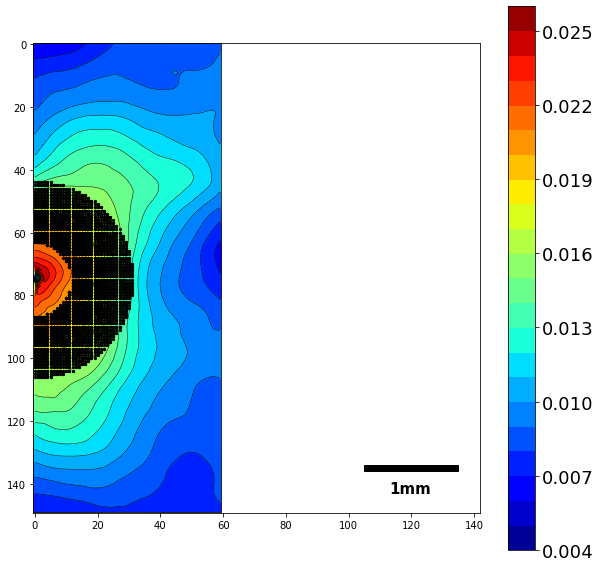

In [93]:
import mecha.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mecha.fracture as fracture
from scipy import io
import matplotlib.patches as patches

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

num = '3'
# pick point
radius_gap = 1.5
gap_count = 21
start_gap = 0.4


scale_factor =2

path = r'E:\experiment data\aluminum\2021-03-30_cts\3_normal'

uu = io.loadmat(path+'/DIC_img/data'+'/'+num+'_uu.mat')['uu']
vv = io.loadmat(path+'/DIC_img/data'+'/'+num+'_vv.mat')['vv']
uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )
exx = io.loadmat(path+'/DIC_img/data'+'/'+num+'_exx.mat')['exx']
eyy = io.loadmat(path+'/DIC_img/data'+'/'+num+'_eyy.mat')['eyy']
exy = io.loadmat(path+'/DIC_img/data'+'/'+num+'_exy.mat')['exy']
ee = fracture.effective_strain(exx, eyy, exy)
exx_resize = cv2.resize(exx,(0,0),fx=scale_factor, fy=scale_factor )
eyy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )
exy_resize = cv2.resize(eyy,(0,0),fx=scale_factor, fy=scale_factor )
ee_resize = cv2.resize(ee,(0,0),fx=scale_factor, fy=scale_factor )


# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000

# Img parameter

contour_level = 20
ratio = 2/60
left, right, up_down = 0,60,75

image = dic.load_file(path+'/img')

strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))

crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x
num = int(num)
dst_dic = ee_resize[crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]
dst_dic = dst_dic.astype(float)
dst_dic = np.where(dst_dic>10, dst_dic*0, dst_dic)
gas = dst_dic

max_crack_tip = [left, up_down]

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,90,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,90,0)))
        radius_g += radius_gap

df = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df.x = df.x + max_crack_tip[0]
df.y = df.y + max_crack_tip[1]
df.r = df.r*0.001


hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df[['y','x','angle']]):
    effective_strain = gas[np.round(y).astype(int),np.round(x).astype(int)]
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])

df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list

plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus
elastic_k1 = np.sqrt((j_integral * youngs_modulus))

fig, ax = plt.subplots(figsize=(10, 10))
ax.add_patch(
     patches.Rectangle(
        (105, 134),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
plt.text( 113,143, '1mm', fontsize=15, fontweight='bold')
ax.imshow(gas, cmap='gray')
csf = ax.contourf(gas, contour_level, cmap = 'jet')
CS = ax.contour(gas, contour_level, colors='black', linewidths = 0.5)
cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)

# ax.axis('off')
plt.scatter(df['x'],df['y'],color='black',s=5)
plt.scatter(left, up_down, s = 10,  c = 'black')
print('j_integral(kj/m^2):', 1000*j_integral)
plt.savefig(path+'/{}_basic.png'.format(num), dpi=300,bbox_inches='tight')

<ipython-input-89-826835a402ef>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)
<ipython-input-89-826835a402ef>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels)
<ipython-input-89-826835a402ef>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(labels)


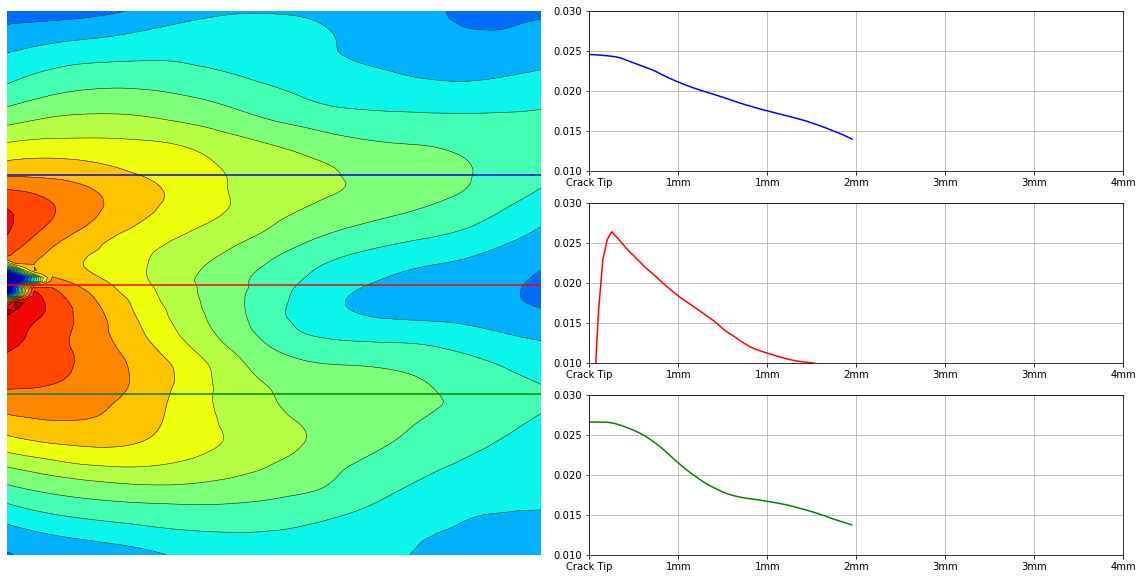

In [89]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pickle
plt.rcParams.update({'font.size': 10})

ee_resize = dst
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(nrows=3, ncols=4)
ax0 = fig.add_subplot(gs[0:3, 0:2])
csf = ax0.contourf(gas/150, contour_level, cmap = 'jet')
CS = ax0.contour(gas/150, contour_level, colors='black', linewidths = 0.5)
# ax0.vlines(50,0,np.shape(ee_resize)[0]-1, color='black', linestyles='-.')

plt.gca().invert_yaxis()
ax0.axis('off')


ax0.hlines(45,0,np.shape(ee_resize)[1]-1, color='blue')
ax2 = fig.add_subplot(gs[0, 2:4])
ax2.plot(gas[45,:], color='blue')
ax2.set_ylim(0.01,0.03)
ax2.set_xlim(0,120)
ax2.grid()

ax0.hlines(75,0,np.shape(ee_resize)[1]-1, color='red')
ax3 = fig.add_subplot(gs[1, 2:4])
ax3.plot(gas[75,:], color='red')
ax3.set_ylim(0.01,0.03)
ax3.set_xlim(0,120)
ax3.grid()

ax0.hlines(105,0,np.shape(ee_resize)[1]-1, color='green')
ax4 = fig.add_subplot(gs[2, 2:4])
ax4.plot(gas[105,:], color='green')
ax4.set_ylim(0.01,0.03)
ax4.set_xlim(0,120)
ax4.grid()


labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'Crack Tip'
for i in range(1,7):
    labels[i] = str(round(20*i*ratio))+'mm'

ax2.set_xticklabels(labels)
ax3.set_xticklabels(labels)
ax4.set_xticklabels(labels)

plt.savefig(path+'/dic_profile.png', dpi= 300,bbox_inches='tight')


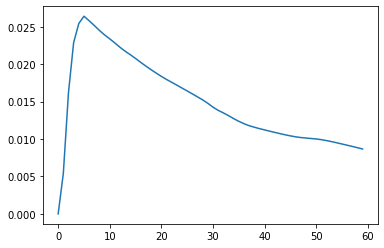

In [88]:

import pickle
plt.plot(gas[75,:])
with open(path+r'/dic_line.pkl','wb') as f:
    pickle.dump(gas, f)
